# Setup

---


Import TensorFlow and other necessary libraries:


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import pathlib

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

2023-05-11 22:00:33.471295: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-11 22:00:33.953348: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-11 22:00:33.953368: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-05-11 22:00:35.338217: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

# Importing Images on Local Machine

---

In [3]:
import pathlib
data_dir = '../SFSU_Art'
data_dir = pathlib.Path(data_dir)
print(data_dir)


../SFSU_Art


# Load Data
---


In [7]:
batch_size = 32
img_height = 260
img_width = 260

# Training data  
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

#Validation Data
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names
with open('./models/label.txt', 'w') as f:
    f.writelines(str(item) + '\n' for item in class_names)



Found 188 files belonging to 6 classes.
Using 151 files for training.
Found 188 files belonging to 6 classes.
Using 37 files for validation.


['Buckeye', 'Gator_Spirit', 'St_Francis', 'couple', 'pole', 'we_stand']


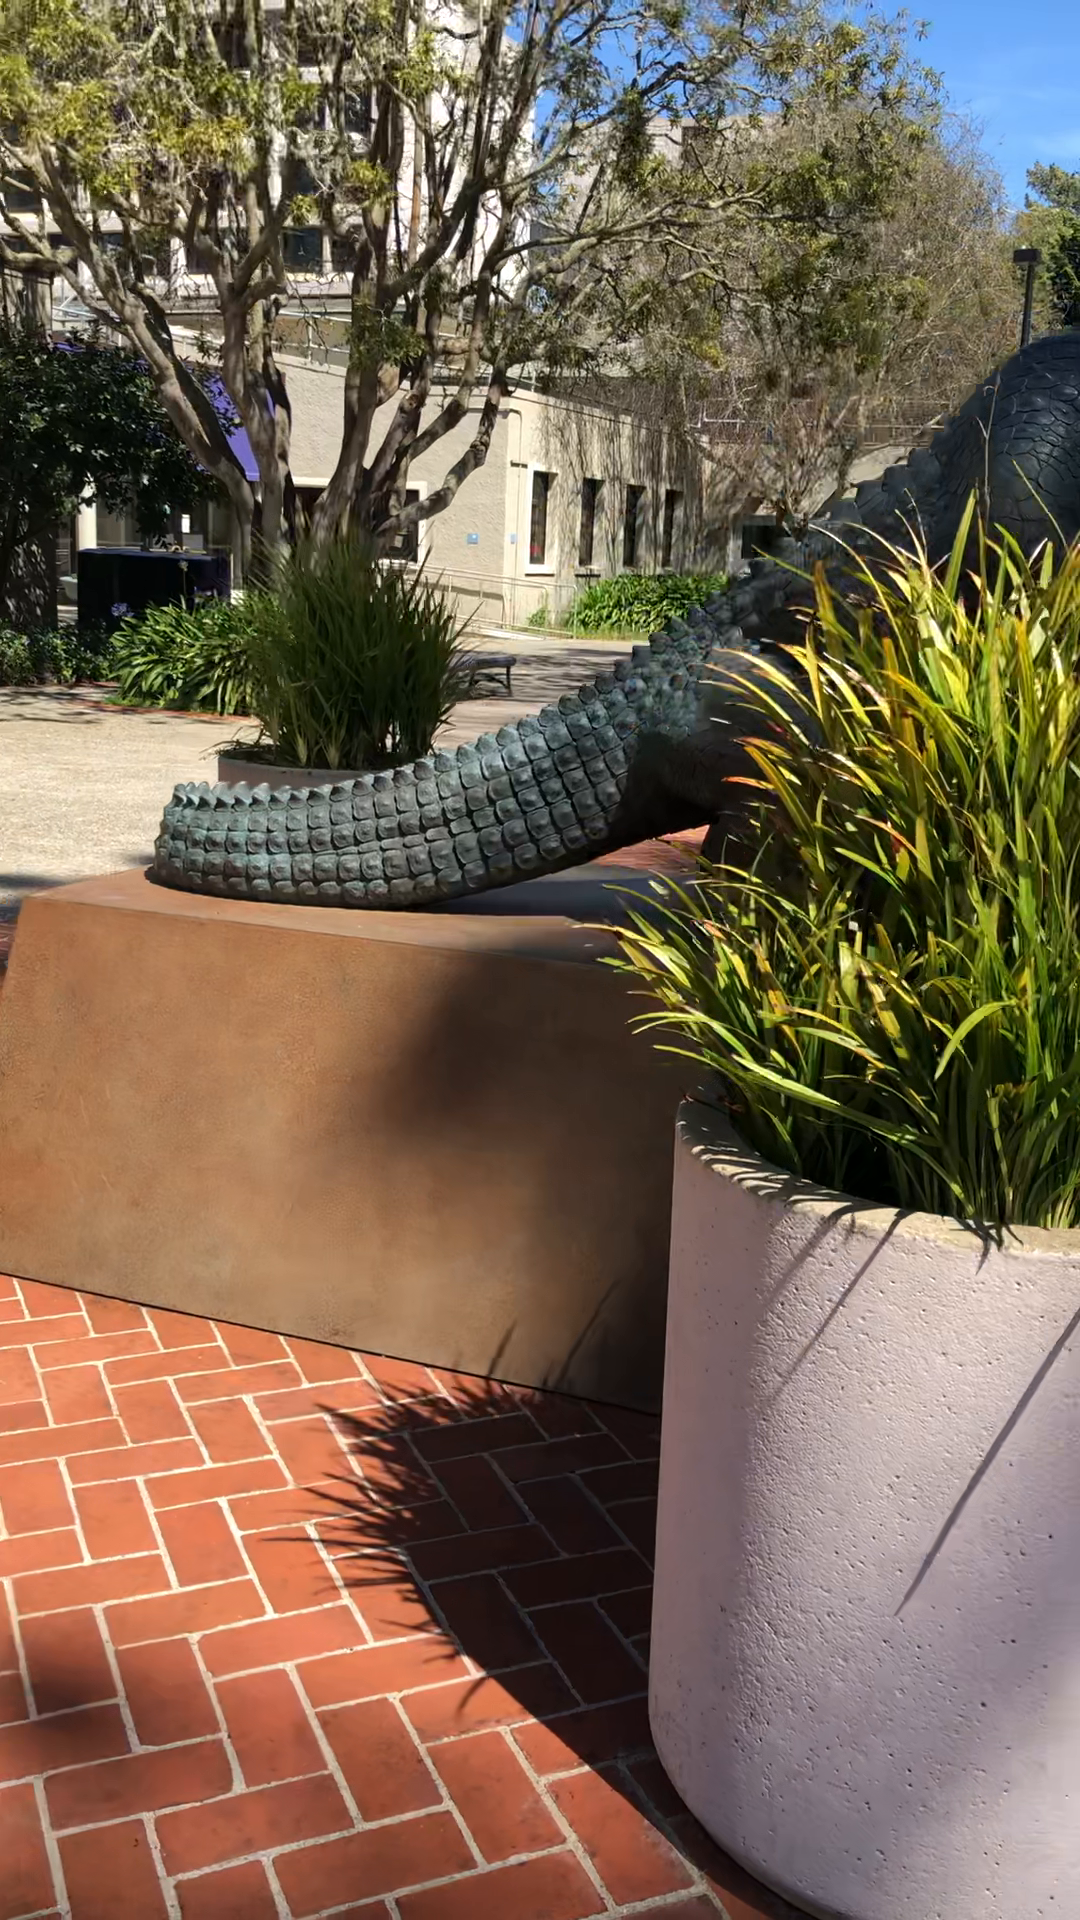

In [6]:
#Display the different class names 
print(class_names)

#Display 1 an image from the categories
gator = list(data_dir.glob('Gator_Spirit/*'))
PIL.Image.open(str(gator[5]))


# Create a Dataset

According to TensorFlow it is a good practice to use 80% of the images for training and 20% for validation.

In [ ]:
#View first 9 images

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")



In [13]:
#Performance Tuning 
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


# Standardize the data

---
The RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general you should seek to make your input values small.

Here, you will standardize values to be in the [0, 1] range by using tf.keras.layers.Rescaling:

In [14]:
normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))


0.0 1.0


# Basic Keras model

The Keras Sequential model consists of three convolution blocks (tf.keras.layers.Conv2D) with a max pooling layer (tf.keras.layers.MaxPooling2D) in each of them. There's a fully-connected layer (tf.keras.layers.Dense) with 128 units on top of it that is activated by a ReLU activation function ('relu'). This model has not been tuned for high accuracy; the goal of this tutorial is to show a standard approach.

In [17]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


# Data Augmentation
---


In [18]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)


# Dropout

In [19]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])


# Compile

In [20]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 260, 260, 3)       0         
                                                                 
 rescaling_5 (Rescaling)     (None, 260, 260, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 260, 260, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 130, 130, 16)     0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 130, 130, 32)      4640      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 65, 65, 32)       0         
 g2D)                                                 

# Train
---

In [21]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
5/5 [==============================] - 16s 2s/step - loss: 4.1579 - accuracy: 0.2914 - val_loss: 1.6964 - val_accuracy: 0.3243
Epoch 2/15
5/5 [==============================] - 10s 2s/step - loss: 1.8280 - accuracy: 0.2185 - val_loss: 1.6032 - val_accuracy: 0.4054
Epoch 3/15
5/5 [==============================] - 14s 3s/step - loss: 1.6251 - accuracy: 0.3907 - val_loss: 1.2646 - val_accuracy: 0.6486
Epoch 4/15
5/5 [==============================] - 8s 2s/step - loss: 1.2440 - accuracy: 0.6424 - val_loss: 0.8469 - val_accuracy: 0.7568
Epoch 5/15
5/5 [==============================] - 10s 2s/step - loss: 0.7419 - accuracy: 0.8013 - val_loss: 0.6531 - val_accuracy: 0.8108
Epoch 6/15
5/5 [==============================] - 8s 2s/step - loss: 0.3448 - accuracy: 0.9338 - val_loss: 0.6485 - val_accuracy: 0.8108
Epoch 7/15
5/5 [==============================] - 8s 2s/step - loss: 0.1949 - accuracy: 0.9338 - val_loss: 1.2773 - val_accuracy: 0.7568
Epoch 8/15
5/5 [=====================

# Visualize training results
---


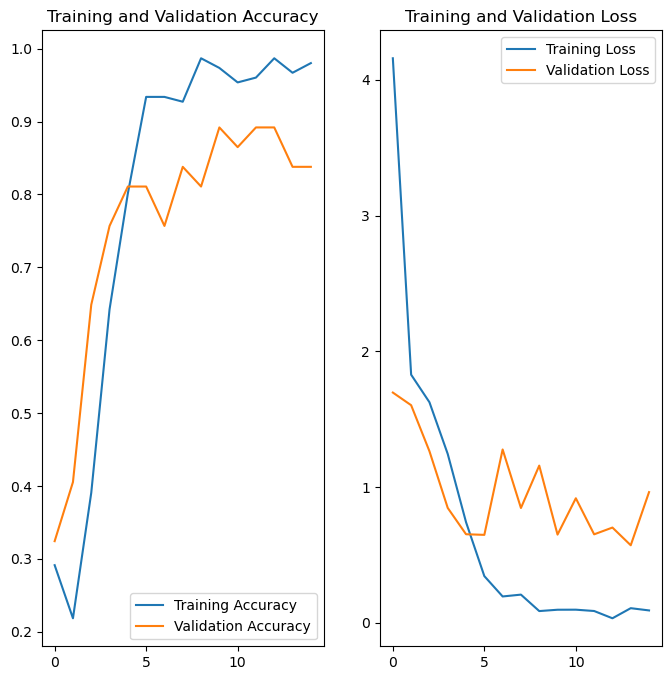

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


# Convert to TensorFlow Lite


---


In [24]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('basic_keras.tflite', 'wb') as f:
  f.write(tflite_model)


INFO:tensorflow:Assets written to: /tmp/tmpvkao39af/assets


INFO:tensorflow:Assets written to: /tmp/tmpvkao39af/assets
2023-05-11 22:33:33.651823: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2023-05-11 22:33:33.651852: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2023-05-11 22:33:33.652017: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpvkao39af
2023-05-11 22:33:33.665342: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-05-11 22:33:33.665377: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpvkao39af
2023-05-11 22:33:33.722962: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2023-05-11 22:33:33.902268: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpvkao39af
2023-05-11 22:33:33.966691: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

In [26]:

TF_MODEL_FILE_PATH = 'basic_keras.tflite' # The default path to the saved TensorFlow Lite model

interpreter = tf.lite.Interpreter(model_path=TF_MODEL_FILE_PATH)

interpreter.get_signature_list()


{'serving_default': {'inputs': ['sequential_3_input'], 'outputs': ['outputs']}}

# Export Regular model 
---

In [31]:
# Export the model
model.save('./models/basic')

INFO:tensorflow:Assets written to: ./models/basic/assets


INFO:tensorflow:Assets written to: ./models/basic/assets


# Feed the model an image

In [46]:
import tensorflow as tf
from tensorflow import keras

# load the model
model = keras.models.load_model('./models/basic')

# load the image and preprocess it
img = keras.preprocessing.image.load_img(
    './a006.png',
    target_size=(260, 260)  # resize image to match the input shape of the model
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # add batch dimension
img_array = keras.applications.mobilenet_v2.preprocess_input(img_array)  # apply preprocessing

# make a prediction
preds = model.predict(img_array)
print(preds)

#testing 
for img, label in test_data.take(1):
    # Get model predictions for the test image
    predictions = model.predict(image)
    
    # Get the predicted label index with the highest probability
    predicted_label = tf.argmax(predictions, axis=1)[0]
    
    # Convert the predicted label index to a string label using the labels list
    predicted_label = labels[predicted_label]
    
    # Get the true label index and convert it to a string label using the labels list
    true_label = labels[label[0]]
    
    # Print the true and predicted labels with their corresponding probabilities
    print("True Label: {} ({:.2f}%)".format(true_label, 100*tf.reduce_max(predictions).numpy()))
    print("Predicted Label: {} ({:.2f}%)".format(predicted_label, 100*predictions[0][predicted_label].numpy()))


1/1 [==============================] - 0s 85ms/step
[[-1.9188312  4.100902   7.7635036 -0.1590668 -4.697446  -1.6701591]]


NameError: name 'test_data' is not defined